In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv(r"C:\Users\habde\OneDrive\Desktop\uni\Semster 5\Intellgent programming\IP_final\tech_support_meaningful_4000.csv")
df.sample(5)

,Conversation_ID,Customer_Issue,Tech_Response,Resolution_Time,Issue_Category,Issue_Status
2253,CONV-2254,Cannot connect to Wi-Fi,Clear cache and remove unnecessary programs.,105 minutes,Network,Resolved after follow-up
2520,CONV-2521,Cannot connect to Wi-Fi,Clear cache and remove unnecessary programs.,65 minutes,Network,Escalated
1121,CONV-1122,Cannot access shared drive,Check network settings and reconnect.,93 minutes,Network,Resolved
3424,CONV-3425,Printer not responding,Check printer connections.,84 minutes,Hardware,Escalated
558,CONV-0559,Printer not responding,Check printer connections.,36 minutes,Hardware,Resolved after follow-up


In [4]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords once
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))

# Function to clean any text
def clean_text(text):
    if pd.isna(text):
        return ""
    
    # 1. lowercase
    text = text.lower()
    
    # 2. remove punctuation & special characters
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 3. remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    return " ".join(words)

# Automatically clean all object (text) columns
text_columns = df.select_dtypes(include=["object"]).columns

for col in text_columns:
    df[col] = df[col].apply(clean_text)

# Save cleaned dataset
df.to_csv("cleaned_dataset.csv", index=False)

df.sample(5)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\habde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Conversation_ID,Customer_Issue,Tech_Response,Resolution_Time,Issue_Category,Issue_Status
222,conv,forgot password,reset password using link provided,minutes,account,pending
444,conv,application crash,reinstall application,minutes,software,pending
565,conv,cannot access shared drive,verify network permissions,minutes,network,resolved
1413,conv,slow system performance,clear cache remove unnecessary programs,minutes,software,pending
1094,conv,slow system performance,restart computer,minutes,software,escalated


In [5]:
print(df['Customer_Issue'].value_counts())


Customer_Issue
software installation failure    437
printer responding               425
cannot print document            413
cannot connect wifi              410
unable access email              393
blue screen error                390
slow system performance          385
application crash                385
cannot access shared drive       382
forgot password                  380
Name: count, dtype: int64


In [6]:
print(df['Tech_Response'].value_counts())


Tech_Response
reinstall printer drivers                  357
check printer connections                  356
check network settings reconnect           340
clear cache remove unnecessary programs    264
run system diagnostic tool                 262
restart computer                           248
follow software installation guide         245
contact administrator password reset       200
reset password using link provided         180
verify network permissions                 169
verify system requirements                 161
restart router                             153
update system drivers                      143
reinstall software                         141
check system compatibility                 140
verify email settings                      140
run antivirus scan remove threats          131
restart printer computer                   125
update application                         123
reinstall application                      122
Name: count, dtype: int64


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Use the text column that contains problem descriptions
text_col = "Customer_Issue"

# ---------------------- TF-IDF VECTORIZATION ----------------------
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df[text_col])

In [8]:
from sklearn.neighbors import NearestNeighbors
# ---------------------- k-NN MODEL ----------------------
knn = NearestNeighbors(n_neighbors=3, metric="cosine")
knn.fit(X_tfidf)


NearestNeighbors(metric='cosine', n_neighbors=3)

In [10]:
# ---------------------- CBR RETRIEVAL FUNCTION ----------------------
def retrieve_similar_tickets(query):
    # Clean the query quickly (lowercase + remove punctuation)
    query_tfidf = tfidf.transform([query])
    
    distances, indices = knn.kneighbors(query_tfidf)
    
    print("\nTop similar cases:")
    for idx, dist in zip(indices[0], distances[0]):
        print(f"Similarity: {1-dist:.2f}")
        print(f"Past Issue: {df.loc[idx, 'Customer_Issue']}")
        print(f"Suggested Solution: {df.loc[idx, 'Tech_Response']}")
        print("-"*60)

# Example query
query = "my Printer is not working"
retrieve_similar_tickets(query)



Top similar cases:
Similarity: 0.71
Past Issue: printer responding
Suggested Solution: check printer connections
------------------------------------------------------------
Similarity: 0.71
Past Issue: printer responding
Suggested Solution: reinstall printer drivers
------------------------------------------------------------
Similarity: 0.71
Past Issue: printer responding
Suggested Solution: check printer connections
------------------------------------------------------------


In [12]:

issues = df["Customer_Issue"].astype(str).tolist()
solutions = df["Tech_Response"].astype(str).tolist()

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(solutions)   # numeric labels
num_classes = len(le.classes_)


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(issues)
X_seq = tokenizer.texts_to_sequences(issues)
max_len = max(len(seq) for seq in X_seq)
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10,          # stop if val_loss doesn't improve for 3 epochs
    restore_best_weights=True
)


In [16]:
from sklearn.model_selection import train_test_split

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_pad, y, test_size=0.2, random_state=42, stratify=y
)


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, BatchNormalization, Dropout

embedding_dim = 64
gru_units = 128

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    GRU(gru_units, dropout=0.2, recurrent_dropout=0.2),  # Dropout inside GRU
    BatchNormalization(),
    Dropout(0.3),                                        # Dropout after GRU
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\habde\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.1,  # 10% of training data used for validation
    callbacks=[early_stop], # EarlyStopping callback
    shuffle=True            # Recommended when using Dropout/GRU
)


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2966 - loss: 2.0286 - val_accuracy: 0.4094 - val_loss: 2.6732
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3815 - loss: 1.1565 - val_accuracy: 0.4031 - val_loss: 2.4633
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3789 - loss: 1.1381 - val_accuracy: 0.3781 - val_loss: 2.1808
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3938 - loss: 1.1121 - val_accuracy: 0.3781 - val_loss: 1.8078
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4103 - loss: 1.1142 - val_accuracy: 0.3844 - val_loss: 1.4413
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3734 - loss: 1.1132 - val_accuracy: 0.3875 - val_loss: 1.2104
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3683 - loss: 1.1078 - val_accuracy: 0.4031 - val_loss: 1.0636
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3795 - loss: 1.0904 - val_accuracy: 0.4187 - val_loss

In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4171 - loss: 0.9932
Test Loss: 0.9921, Test Accuracy: 0.3963


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


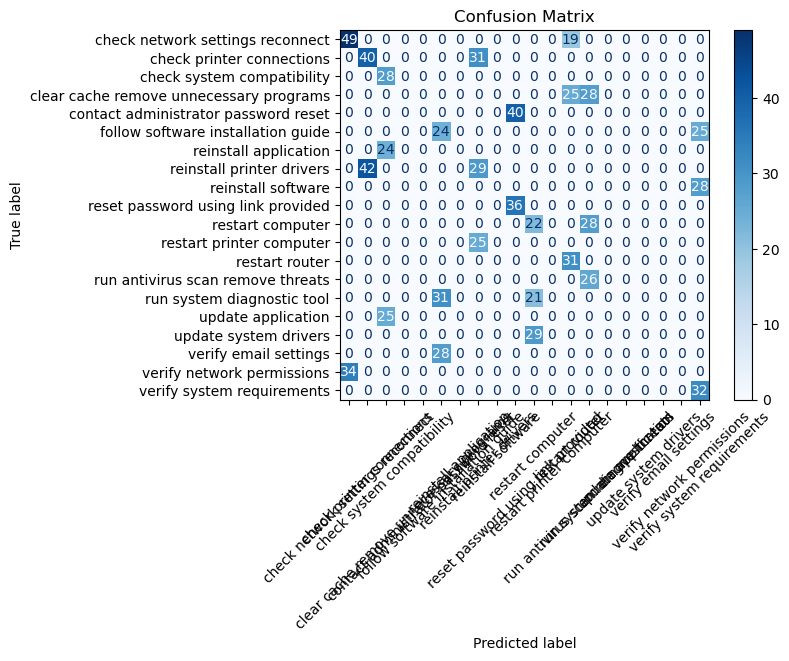

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


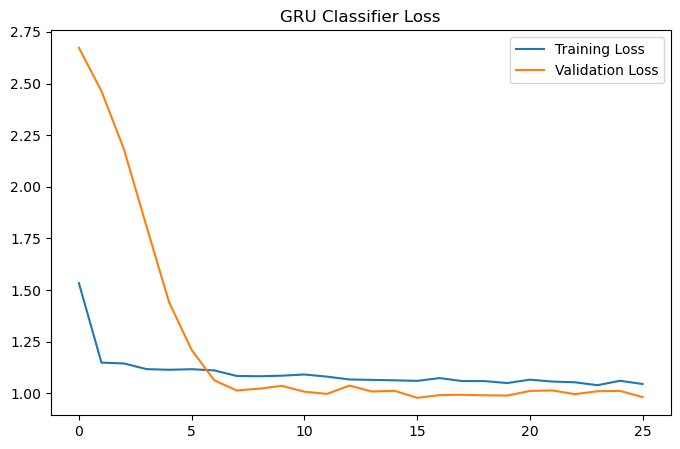

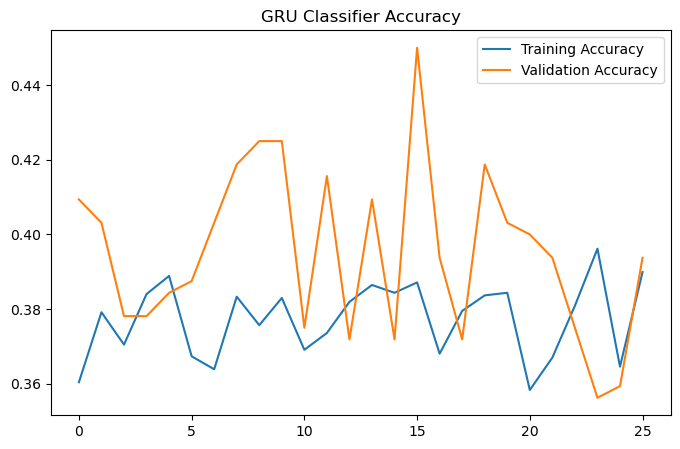

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("GRU Classifier Loss")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("GRU Classifier Accuracy")
plt.show()


In [28]:
def predict_solution(issue_text):
    # 1. Clean the input text
    cleaned = clean_text(issue_text)

    # 2. Convert to sequence
    seq = tokenizer.texts_to_sequences([cleaned])

    # 3. Pad to max length
    pad = pad_sequences(seq, maxlen=max_len, padding='post')

    # 4. Predict class
    pred = model.predict(pad)
    class_id = pred.argmax()

    # 5. Convert class ID → label
    return le.inverse_transform([class_id])[0]


print(predict_solution("my internet connection is slow"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
update application
